# 03 – Modeling & Probability Map

Train a baseline model and render a probability map.


In [3]:
%pip install -q -r ../requirements.txt


Note: you may need to restart the kernel to use updated packages.


Including geology: 18 cols
Including gravity
Including gravity gradient
Including geochem: 8 columns
Including magnetics: 3 cols
X shape: (7646, 33)
Using label set: critical | positives: 3162 | rate: 0.4135495684017787
Calibrated RF — ROC AUC: 1.000 | PR AUC: 0.999
Saved: c:\Users\angel\ore-exploration-ml\ore-exploration-ml\figures\rf_map_critical.png


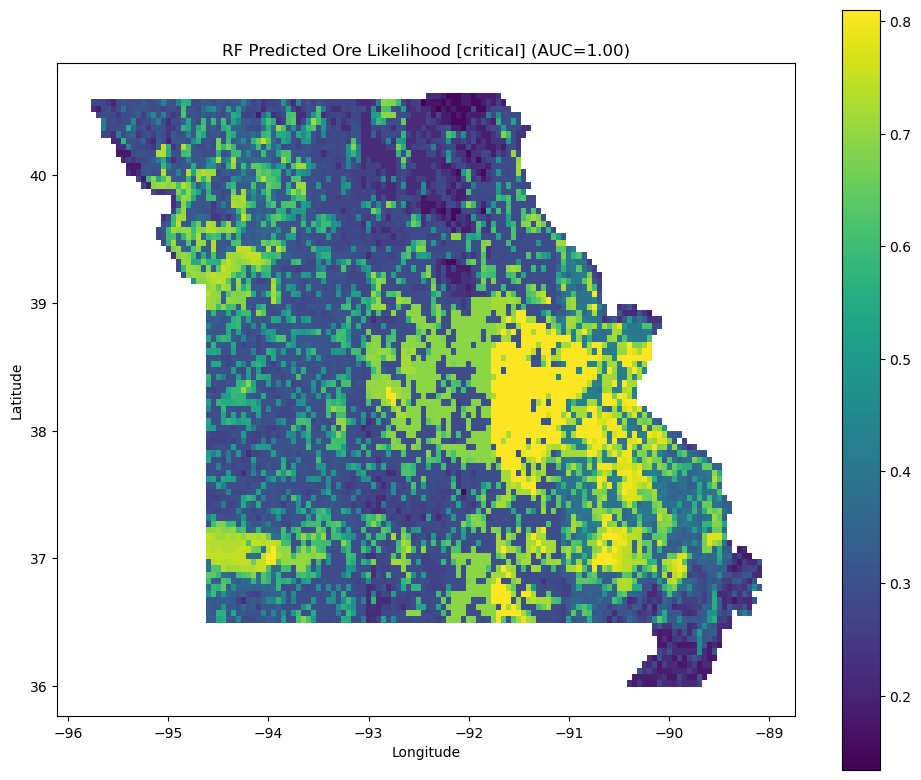

In [4]:
# 03_modeling_and_maps.py  (or notebook cell)

import os
import numpy as np
import joblib
from pathlib import Path
import sys

# Add the project root to sys.path so 'src' can be imported
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score

from src.visualization import plot_probability_map  # assumes your helper returns (fig, ax)

# --------------------
# Load features
# --------------------
Xc = np.load(project_root / 'data/processed/X_coords.npy')
parts = [Xc]

# Optional geology one-hots
geo_path = project_root / 'data/processed/X_geo.npy'
if os.path.exists(geo_path):
    Xg = np.load(geo_path)
    if Xg.shape[0] == Xc.shape[0]:
        parts.append(Xg)
        print(f"Including geology: {Xg.shape[1]} cols")
    else:
        print("Skipping geology (row mismatch)")

# Optional gravity
grav_path = project_root / 'data/processed/X_gravity.npy'
if os.path.exists(grav_path):
    Xgrav = np.load(grav_path).reshape(-1, 1)
    if Xgrav.shape[0] == Xc.shape[0]:
        parts.append(Xgrav)
        print("Including gravity")

# Optional gravity gradient
grad_path = project_root / 'data/processed/X_gravity_grad.npy'
if os.path.exists(grad_path):
    Xgg = np.load(grad_path).reshape(-1, 1)
    if Xgg.shape[0] == Xc.shape[0]:
        parts.append(Xgg)
        print("Including gravity gradient")

# Optional geochemistry
geochem_path = project_root / "data/processed/X_geochem.npy"
if os.path.exists(geochem_path):
    Xgc = np.load(geochem_path)
    if Xgc.shape[0] == Xc.shape[0]:
        parts.append(Xgc)
        print(f"Including geochem: {Xgc.shape[1]} columns")

# Optional magnetic
if os.path.exists(project_root / "data/processed/X_mag.npy"):
    Xmag = np.load(project_root / "data/processed/X_mag.npy")
    if Xmag.shape[0] == Xc.shape[0]:   # or Xc.shape[0] if you build baseline first
        parts.append(Xmag)
        print(f"Including magnetics: {Xmag.shape[1]} cols")

X = np.hstack(parts)
print("X shape:", X.shape)

# --------------------
# Labels (critical preferred)
# --------------------
if os.path.exists(project_root / "data/processed/y_labels_crit.npy"):
    y = np.load(project_root / "data/processed/y_labels_crit.npy")
    LABEL_SET = "critical"
else:
    y = np.load(project_root / "data/processed/y_labels.npy")
    LABEL_SET = "all"

print("Using label set:", LABEL_SET, "| positives:", int(y.sum()), "| rate:", float(y.mean()))

# --------------------
# Grid for mapping
# --------------------
grid = joblib.load(project_root / "data/processed/grid_gdf.joblib")

# --------------------
# Train calibrated RF (better probability calibration)
# --------------------
rf = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)
cal_rf = CalibratedClassifierCV(rf, method="isotonic", cv=5)
cal_rf.fit(X, y)

probs = cal_rf.predict_proba(X)[:, 1]
auc = roc_auc_score(y, probs)
pr_auc = average_precision_score(y, probs)
print(f"Calibrated RF — ROC AUC: {auc:.3f} | PR AUC: {pr_auc:.3f}")

# --------------------
# Save artifacts
# --------------------
os.makedirs(project_root / "models", exist_ok=True)
os.makedirs(project_root / "figures", exist_ok=True)
joblib.dump(cal_rf, project_root / f"models/rf_calibrated_{LABEL_SET}.joblib")
np.save(project_root / f"data/processed/rf_probs_{LABEL_SET}.npy", probs)

# --------------------
# Plot and save figure
# --------------------
title = f"RF Predicted Ore Likelihood [{LABEL_SET}] (AUC={auc:.2f})"
fig, ax = plot_probability_map(grid, probs, title=title)
fig_path = project_root / f"figures/rf_map_{LABEL_SET}.png"
fig.savefig(fig_path, dpi=180, bbox_inches="tight")
print(f"Saved: {fig_path}")


> Tip: Replace coordinate-only features with domain features (geology type, magnetic/gravity anomalies, geochemistry).